In [1]:
%load_ext autoreload
%autoreload 2
# when debugging the python scripts, with the autoreload the jupyter notebook sync's to the most up to date scripts. See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
from dataprep import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scanpy as sc
from scipy.spatial.distance import cdist
from scipy.stats import norm
import torch

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [176]:
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)

custom = {"axes.edgecolor": "grey"}
sns.set_style("whitegrid")
plt.rcParams['grid.alpha'] = 0.4
sns.set_palette("colorblind")

# Like colorblind_palette[4] for control, colorblind_palette[0] for test

## Loading RF Models & Datasets

In [262]:
#adata_all_spots = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/all_spots_simulated_embeddings_adata.h5ad")
#adata_split_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/new_model_with_cell_id_left_out_custom_nynke_panel_simulated_embeddings_adata.h5ad")
#adata_mixed_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/custom_nynke_panel_simulated_embeddings_adata.h5ad")
adata_apical = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/apical_basal_data/moor_data_apical_basal_embeddings_adata.h5ad")

In [250]:
#adata_split_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/new_model_with_cell_id_left_out_custom_nynke_panel_simulated_embeddings_adata.h5ad")
adata_apical = sc.read_h5ad("/media/gambino/students_workdir/moor_data_apical_basal_embeddings_adata_all_nr_spots.h5ad")

In [152]:
def map_interval(interval):
    if interval == '0-10':
        return '0-10'
    elif interval in ['10-20', '20-30']:
        return '10-30'
    elif interval in ['30-40', '40-50', '50-60']:
        return '30-60'
    elif interval in ['70-80', '80-90', '90-100']:
        return '70-100'
    elif interval == '100+':
        return '100+'
    else:
        return None
    
def initialize_adata(adata):
    choices = ['strong', 'intermediate', 'low']
    conditions = [
        (adata.obs['prop'] == 0.9) | ((adata.obs['prop'] == 0.4) & (adata.obs['pattern'] == 'protrusion')),
        (adata.obs['prop'] == 0.5) | ((adata.obs['prop'] == 0.2) & (adata.obs['pattern'] == 'protrusion')),
        (adata.obs['prop'] == 0.1) | ((adata.obs['prop'] == 0.0) & (adata.obs['pattern'] == 'protrusion'))
    ]
    adata.obs['pattern_strength'] = np.select(conditions, choices, default='unknown')

    # Include modified RNA count intervals in the adata object
    adata.obs['rna_count'] = adata.obs['n_spots_interval'].apply(map_interval)


    return adata

In [153]:
adata_split_cellID = initialize_adata(adata_split_cellID)
adata_test = adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])]

# Estimate Probability Density Functions with KDE

Use KDEpy, is a quicker to run than KDE implementations of scipy, sklearn and statsmodel, and you can use a bandwidth estimator called ISJ, which is useful for very non-normal data and potentially multimodal data. 

In [13]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate, EstimatorSettings

In [16]:
pericellular_dict_split_cellID[0]

AnnData object with n_obs × n_vars = 317 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength'
    uns: 'test_cellIDs', 'train_cellIDs'
    obsm: 'latent'

In [6]:
settings = EstimatorSettings(efficient=True, n_jobs=15)

use cross validation least squares to select the bandwidth for each dimension. Choose LS over ML because ML makes assumptions about normality etc, whereas LS does not. 

In [17]:
randomgene = KDEMultivariate(data=random_dict_mixed[0].obsm['latent'], var_type='ccccccccccccccc',bw='cv_ls', defaults=settings)

In [18]:
perigene = KDEMultivariate(data=pericellular_dict_split_cellID[0].obsm['latent'], var_type='ccccccccccccccc',bw='cv_ls', defaults=settings)

In [26]:
randomgene

KDE instance
Number of variables: k_vars = 15
Number of samples:   nobs = 317
Variable types:      ccccccccccccccc
BW selection method: cv_ls

Creating the grid to turn the KDE into PDF

In [24]:
# Assuming point_cloud_1 and point_cloud_2 are your two point clouds
combined = np.concatenate([random_dict_mixed[0].obsm['latent'], pericellular_dict_split_cellID[0].obsm['latent']], axis=0)  # Combine the point clouds

# Find the minimum and maximum values across all dimensions and points
min_val = min(np.min(random_dict_mixed[0].obsm['latent']),np.min(pericellular_dict_split_cellID[0].obsm['latent']))
max_val = max(np.max(random_dict_mixed[0].obsm['latent']),np.max(pericellular_dict_split_cellID[0].obsm['latent']))
num_points = 100  # number of points in each latent dimension

# Create the grid
grid = np.linspace(min_val, max_val, num_points)

In [23]:
combined.shape

(634, 15)

In [ ]:
pdf_random = randomgene.pdf(data_predict=grid)
pdf_peri = perigene.pdf(data_predict=grid)

# Chamfer Distance

In [6]:
def chamfer_L1_distance(point_cloud_1, point_cloud_2):

    # Compute all pairwise Manhattan distances, output matrix = [distance_cloudA1, distance_cloud2]
    distances_1_to_2 = cdist(point_cloud_1, point_cloud_2, metric='cityblock')
    distances_2_to_1 = cdist(point_cloud_2, point_cloud_1, metric='cityblock')

    # Get nearest neighbor for each point from point cloud 1 in point cloud 2 and vice versa
    distances_1_to_2 = np.min(distances_1_to_2, axis=1)
    distances_2_to_1 = np.min(distances_2_to_1, axis=1)

    # Compute the Chamfer distance
    return np.mean(distances_1_to_2) + np.mean(distances_2_to_1)

In [6]:
strength = 'strong'
count = '10-30'
sample = 5

pattern = subset_power_analysis(adata_test, mixed_patterns = True, pattern_strength= strength, rna_count = count, sample_size = sample)
control = subset_power_analysis(adata_test, pattern = 'random', mixed_patterns = False, rna_count = count, sample_size = sample)

#### permutation function

In [8]:
from latent_statistics import permutation_test
#permutation_test(pattern, control, n_permutations: int = 1000)
# Perform permutation test
p_value, observed_statistic, permuted_statistics = permutation_test(
    pattern.obsm['latent'], 
    control.obsm['latent'], 
    n_permutations=9999)

print(f"Observed chamfer distance: {observed_statistic}")
print(f"P-value: {p_value}")

252.0
Observed chamfer distance: 115.9771185040474
P-value: 0.015873015873015872


In [52]:
def permutation_test(pattern, control, n_permutations: int = 1000):
    observed_statistic = chamfer_L1_distance(pattern, control)
    num_pattern = len(pattern)
    combined = np.concatenate([pattern, control])
    
    # Preallocate permuted null hypothesis array
    permuted_statistics = np.empty(n_permutations)

    for i in range(n_permutations):
        permuted = np.random.permutation(combined)
        permuted_pattern = permuted[:num_pattern]
        permuted_control = permuted[num_pattern:]
        permuted_statistic = chamfer_L1_distance(permuted_pattern, permuted_control)
        permuted_statistics[i] = permuted_statistic
    
    #These functions come from scipy.stats.permutation_test(). They have now been integrated in my main function in line to improve the efficiency
    eps =  (0 if not np.issubdtype(observed_statistic.dtype, np.inexact)
            else np.finfo(observed_statistic.dtype).eps*100)
    gamma = np.abs(eps * observed_statistic)
    cmps_less = permuted_statistics <= observed_statistic + gamma
    cmps_greater = permuted_statistics >= observed_statistic - gamma
    # +1 is added to pvalues to add the observed value into the hypothetical population to make the pvalue more conservative.
    pvalues_less = (cmps_less.sum() + 1) / (n_permutations + 1)
    pvalues_greater = (cmps_greater.sum() + 1) / (n_permutations + 1)
    #because with 2-tailed you should use alpha=0.025 as treshold, so now it gets scaled back to 0.05
    p_value = np.minimum(pvalues_less, pvalues_greater) * 2 

    return p_value, observed_statistic, permuted_statistics

In [206]:
n_spots = adata_apical[adata_apical.obs['genes']=='Slc39a14'].obs['n_spots'].to_numpy()
print(len(n_spots))
print(np.mean(n_spots))
print(np.median(n_spots))
print(np.std(n_spots))
print(np.min(n_spots))
print(np.max(n_spots))

389
5.4910025706940875
5.0
3.7633117658910704
1
23


In [69]:
adata_test

AnnData object with n_obs × n_vars = 329349 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength', 'rna_count', 'apop_count'
    uns: 'test_cellIDs', 'train_cellIDs'
    obsm: 'latent'

In [270]:
def map_interval(interval):
    if interval in ['10-20']:
        return '10-20'
    else:
        return None
    
adata_test.obs['apob_count'] = adata_test.obs['n_spots_interval'].apply(map_interval)


In [238]:
def subset_power(adata, pattern: str = 'pericellular', mixed_patterns: bool = True, pattern_strength: str = "strong", rna_count: str = '10-30', sample_size: int = 5, random_seed: bool = False):
    """
    Subset the anndata object into a `1 gene multiple cells` object. Can filter the cells based on the number of spots, the pattern and the pattern strength.

    Parameters
    ----------
    adata : ad.AnnData object
        complete anndata object.
    pattern : str
        Type of subcellular expression pattern you want to filter on. Default is 'pericellular', which has the highest f1 RF score.
    mixed_patterns: bool
        True: all patterns can be included, False: only the pattern type specified in `pattern` is included. Default is False. 
    pattern_strength : str
        strength of the pattern, which is labeled as pattern_strength in the anndata object. Strong, which comes down to 45% of points fall in the pattern for protrusion, 90% of points are in pattern for all the other patterns. 
        If the pattern is random, then pattern_strength is not used, given that irrelevant for random when using the simFISH v2 definition of patterness (90% of points assigned to the pattern 'random' will still amount to 100% randomness).
    high_or_low : str
        Whether you want to filter genes with a higher or lower count than the given threshold. Default is lower.
        If none, then no threshold is chosen and mixed counts are included. 
    count_threshold : int
        Count threshold to filter on. Default is 11, so that genes with count 0-10 are selected. For high, the threshold is 140.
    mixed_counts: bool
        True: all counts are included, False: only counts above or below the threshold are included. Default is False.
        
    Returns
    -------
    ad.AnnData

    """
    adata_filtered = adata[(
                                (
                                    adata.obs['pattern'] == pattern if mixed_patterns == False
                                    else adata.obs['pattern'] != 'random'
                                )
                            ) & 
                           (
                                adata.obs['apob_count'] == rna_count
                            ) & 
                           (
                               adata.obs['pattern_strength'] == pattern_strength if pattern != 'random' 
                               else True
                            )
                        ].copy()

    if random_seed == True:
        subset = adata_filtered.obs.sample(n=sample_size, random_state = seed) 
    else:
        subset = adata_filtered.obs.sample(n=sample_size)
    
    adata_subset = adata_filtered[adata_filtered.obs.index.isin(subset.index)]


    return adata_subset

In [57]:
adata_test.obs['apob_count'].value_counts()

20-50    67489
0-20     36383
Name: apob_count, dtype: int64

In [46]:
len(adata_apical[adata_apical.obs['genes']=='Cdkn1a'])
Slc39a14

376

In [271]:
pattern = adata_apical[adata_apical.obs['genes']=='Slc39a14'].obsm['latent']
control = subset_power(adata_test, pattern = 'random', mixed_patterns = False, rna_count = '10-20', sample_size = len(pattern), random_seed=True)

In [267]:
# Perform permutation test
p_value, observed_statistic, permuted_statistics = permutation_test(
    pattern, 
    control.obsm['latent'], 
    n_permutations=9999)

print(f"Observed chamfer distance: {observed_statistic}")
print(f"P-value: {p_value}")

Observed chamfer distance: 46.79462432861328
P-value: 0.0001


In [20]:
path = f"/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_pattern_balanced_singlejob.pkl"
with open(path, 'rb') as p:
    rf_pattern_balanced_singlejob = pickle.load(p)

In [113]:
from latent_statistics import permutation_test
from scipy.stats import ks_2samp
import pickle

In [272]:
pattern_score = rf_pattern_balanced_singlejob.predict_proba(pattern)[:,1]
control_score = rf_pattern_balanced_singlejob.predict_proba(control.obsm["latent"])[:,1]

statistic, pvalue = ks_2samp(pattern_score, control_score)
print(f"Observed KS statistic: {statistic}")
print(f"P-value: {pvalue}")

Observed KS statistic: 0.4
P-value: 0.003018184077228396


In [101]:
test1 = subset_power_analysis(adata_test, pattern = 'random', mixed_patterns = False, rna_count = '10-30', sample_size = 70)

In [185]:
colorblind_palette = sns.color_palette("colorblind")
colorblind_palette

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [188]:
plt.rcParams['grid.alpha'] = 0.4

34
31


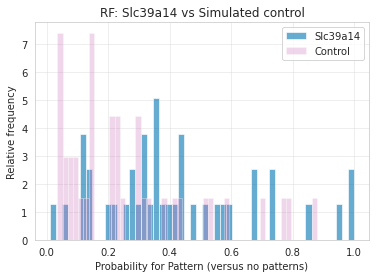

In [274]:

print(len(np.unique(pattern_score)))
print(len(np.unique(control_score)))

#plt.hist(random_low['prob_pattern'], bins=30, alpha=0.4, label='Random', density=True)
plt.hist(pattern_score, bins=50, alpha=0.6, label='Slc39a14', density=True, color=colorblind_palette[0])
plt.hist(control_score, bins=50, alpha=0.3, label='Control', density=True, color=colorblind_palette[4])


plt.title(f"RF: Slc39a14 vs Simulated control")
plt.legend(loc='upper right')
plt.xlabel("Probability for Pattern (versus no patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [114]:
# Perform permutation test
p_value, observed_statistic, permuted_statistics = permutation_test(
    pattern, 
    control.obsm['latent'], 
    n_permutations=9999)

print(f"Observed chamfer distance: {observed_statistic}")
print(f"P-value: {p_value}")

Observed chamfer distance: 67.43435668945312
P-value: 0.0001


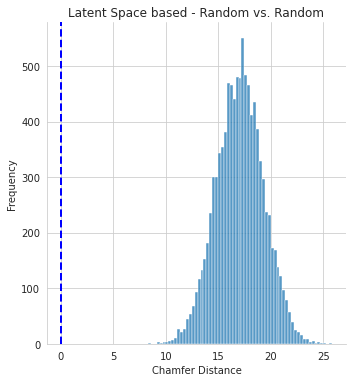

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create histogram with seaborn
sns.displot(permuted_statistics, bins='auto', kde=False)

# Add vertical line at observed statistic
plt.axvline(x=observed_statistic, color='b', linestyle='dashed', linewidth=2)

# Add labels and title
plt.title('Latent Space based - Random vs. Random')
plt.xlabel('Chamfer Distance')
plt.ylabel('Frequency')

# Show plot
plt.show()

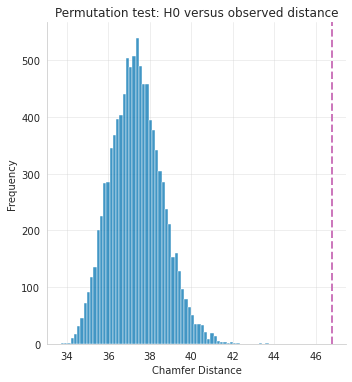

In [282]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create histogram with seaborn
sns.displot(permuted_statistics, bins='auto', kde=False)

# Add vertical line at observed statistic
plt.axvline(x=observed_statistic, color=colorblind_palette[4], linestyle='dashed', linewidth=2)

# Add labels and title
plt.title('Permutation test: H0 versus observed distance')
plt.xlabel('Chamfer Distance')
plt.ylabel('Frequency')

# Show plot
plt.show()

In [17]:
print(chamfer_L1_distance(pattern.obsm['latent'], control.obsm['latent']))

44.71541587377258


In [21]:
print(chamfer_L1_distance(random_dict_mixed[0].obsm['latent'], random_dict_mixed[2].obsm['latent']))

34.27557134989247
